In [1]:
import sys
from os import path
sys.path.append(path.join(path.abspath('..'), 'src'))

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from os import path
import time

import config
import utils
import model

import tensorflow as tf
sess = tf.InteractiveSession()
from tensorflow.examples.tutorials.mnist import input_data

____section____ = utils.section_print()
mnist = input_data.read_data_sets(
    path.join(config.path_main, 'MNIST_data'), one_hot=True)

____section____('Generate synthetic bounding boxes')

train = utils.reshape_to_img(mnist.train.images)
validation = utils.reshape_to_img(mnist.validation.images)
test = utils.reshape_to_img(mnist.test.images)

bounds_train = utils.get_data_to_box(train) * 1. / 28
bounds_validation = utils.get_data_to_box(validation) * 1. / 28
bounds_test = utils.get_data_to_box(test) * 1. / 28

bounding_box_grid_generated = utils.plot_bounding_grid(
    df=train,
    subplot_shape=(4, 6),
    bounding_boxes=bounds_train,
)
bounding_box_grid_generated.savefig(
    path.join(config.path_outputs, 'bounding_box_grid_generated.png'))

Section 0: Initializing section function
Extracting /home/ryan/github/research/MNIST-bounding-box/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/ryan/github/research/MNIST-bounding-box/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/ryan/github/research/MNIST-bounding-box/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/ryan/github/research/MNIST-bounding-box/MNIST_data/t10k-labels-idx1-ubyte.gz
Section 1: Generate synthetic bounding boxes


In [5]:
def add_background_noise(df, treshold=.01, scale=1.):
    noise_mask = df < treshold
    noise_overlay = np.divide(noise_mask, (1 + np.exp(np.random.normal(size=df.shape))))
    return df + noise_overlay

In [12]:
batch_size = 50

In [54]:
X_test = add_background_noise(mnist.test.images)
X_test.reshape((mnist.test.num_examples, 28, 28))

In [14]:
X_train = add_background_noise(mnist.train.images).reshape((mnist.train.num_examples, 28, 28))
X_validation = add_background_noise(mnist.validation.images).reshape((mnist.validation.num_examples, 28, 28))

batch_X_train = np.split(X_train, mnist.train.num_examples / batch_size)
batch_bounds_train = np.split(bounds_train, mnist.train.num_examples / batch_size)

In [21]:
import tensorflow as tf


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [50]:
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 28, 28])
y = tf.placeholder(tf.float32, shape=[None, 4])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 4])
b_fc2 = bias_variable([4])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [51]:
loss = tf.sqrt(tf.reduce_mean(tf.square(y_conv - y)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
correct_prediction = tf.reduce_mean(tf.squared_difference(y_conv, y), 1)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(len(batch_X_train)):
    if i % 50 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch_X_train[i],
            y: batch_bounds_train[i],
            keep_prob: 1.,
        })
        validation_accuracy = accuracy.eval(feed_dict={
            x: X_validation, y: bounds_validation, keep_prob: 1.
        })
        print("Step {}, training accuracy {:.4f}, validation accuracy: "
              "{:.4f}".format(i, train_accuracy, validation_accuracy))
    train_step.run(feed_dict={
        x: batch_X_train[i],
        y: batch_bounds_train[i],
        keep_prob: 0.5,
    })

print("Training accuracy {:.4f}".format(accuracy.eval(feed_dict={
    x: X_train, y: bounds_train, keep_prob: 1.0})))
print("Validation accuracy {:.4f}".format(accuracy.eval(feed_dict={
    x: X_validation, y: bounds_validation, keep_prob: 1.0})))

pred_validation = y.eval(feed_dict={
    x: X_validation, y: bounds_validation, keep_prob: 1.0})

Step 0, training accuracy 4.3203, validation accuracy: 4.5426
Step 50, training accuracy 0.4095, validation accuracy: 0.5617


KeyboardInterrupt: 

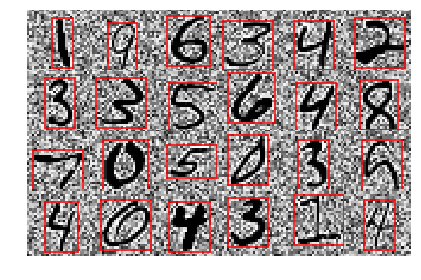

In [46]:
bounding_box_grid_estimated = utils.plot_bounding_grid(
    df=X_validation,
    subplot_shape=(4, 6),
    bounding_boxes=pred_validation,
)
bounding_box_grid_estimated